In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Данные о аренде велосипедов

### Задачи: 

1. Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.


2. Постройте график по числу поездок по дате и времени.


3. Преобразуйте данные и посчитайте число поездок по дням. Визуализируйте результат.


4. Используйте агрегированные данные по дням и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.


5. Посчитайте разницу между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего. Далее – найдите стандартное отклонение.


6. Определите границы 99% доверительного интервала, добавьте данную информацию в датафрейм.


7. Изучите аномально высокие значения и укажите день, когда число аренд было наибольшим. Найдите причину данной аномалии.


8. Изучите аномально низкие значения, найдите день с наименьшим числом аренд. Найдите причину данной аномалии.



### Summary 
1. Предобработала данные, оценила наличие пропущенных значений


2. Построила гистограмму количества арендованных велосипедом по дням, предварительно увеличив шаг разбивки с помощью resample()


3. Для нахождения причины выборосов - рассчитала скользящее среднем с шагом 3, нашла дельту между средним значением по выборке и скользящими, рассчитала 95 % доверительный интервал.


4. Оценила дни, в которых количество наблюдаемых явлений было за верхней и нижней границами доверительного интервала.


5. Обнаружила аномалию, в которой данные за 1 сутки полностью отсутствовали. 



In [3]:
df = pd.read_csv('/Users/kamilamur/data from course/london.csv',parse_dates = ['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
#Оцениваем наличие пропусков(NaN), корректность названия колонок 

df.isna().sum()


timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [5]:
#Оцениваем тип данных, меняем timestamp на формат даты( в строке считывания файла)

df.dtypes


timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [6]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


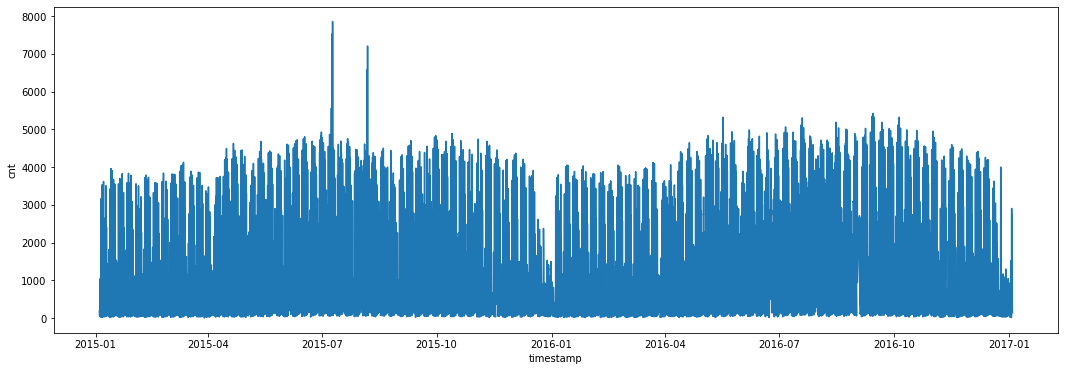

In [7]:
#Для начала попробуем посмотреть на число поездок по времени.

plt.figure(figsize=(18,6))
ax = sns.lineplot(x = 'timestamp', y = 'cnt', data = df)

#Нужна дальнейшая обработка, шаг слишком маленький - мы наблюдаем, сколько было арендовано велосипедов каждый час каждого дня


<AxesSubplot:xlabel='timestamp'>

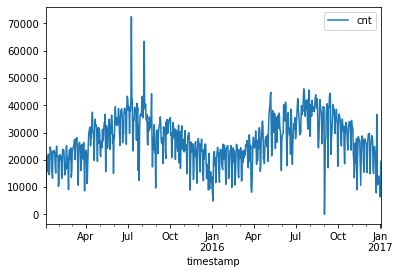

In [8]:
#Используем df.set_index(key,drop), чтобы сделать из колонки - индекс, т.к только индексы использует метод resample

#df.set_index('key', drop=False, inplace=True) - drop - удалять колонку из датафрейма или нет 
#inplace - сразу перезаписать данные в датасет или нет

#Используем функцию resample(rules='D') чтобы посчитать по дням(D) кол-во поездок(cnt.sum) (сгруппирует данные по дням)

df.set_index('timestamp', drop=False, inplace=True)

df.resample('D').agg({'cnt':'sum'}).plot()


## Сделанные наблюдения:

1. Максимальное число аренд за день составляет более 70 000  
2. Зимой число аренд меньше, чем летом  
3. Встречаются как очень резкие скачки числа аренд, так и падения  

### Когда мы видим выбросы как на графике - нужно найти причину:


1. можно рассчитать скользящее среднее  
2. найти разницу между наблюдаемыми и скользящими значениями  
3. найти  99% доверительный интервал  

In [11]:
#Рассчитываем количество наблюдений по дням и сохраняем в переменную

df_sum = df.resample('D').cnt.sum().reset_index()

df_sum.head()

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601


In [12]:
#Рассчитываем скользящее среднее с шагом 3 для количества арендованных велосипедов в день

rolling__mean_df = df.resample('D').cnt.sum().rolling(window=3).mean().reset_index()

rolling__mean_df.head()

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667


In [13]:
#Изначально - это делается для оценки выбросов!! поэтому нужно оценить, как эта разница в среднем отклоняется

#Определяем разницу между изначальными и скользящими значениями, сразу для это разницы рассчитываем std

std_df = np.std(df_sum['cnt'] - rolling__mean_df['cnt'])

round(std_df,2)

4558.59

In [14]:
#Находим 99% доверительный интервал для каждого скользящего среднего

upper_border = rolling__mean_df.cnt + (2.576 * std_df)
lower_border = rolling__mean_df.cnt - (2.576 * std_df)


In [15]:
#оцениваем верхнюю границу для последнего значения

round(upper_border.loc[730],2)


24302.92

In [16]:
#Добавляем границы доверительного интервала в датафрем для дальнейшей оценки

df_sum['upper_border'] = upper_border
df_sum['lower_border'] = lower_border

df_sum.head()

,timestamp,cnt,upper_border,lower_border
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,28482.585854,4996.747479
3,2015-01-07,21064,32425.919188,8940.080812
4,2015-01-08,15601,30835.585854,7349.747479


In [17]:
#Выводим наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

df_sum.query("cnt > upper_border")


,timestamp,cnt,upper_border,lower_border
186,2015-07-09,72504,62447.919188,38962.080812
214,2015-08-06,63468,58370.252521,34884.414146
609,2016-09-04,27512,26001.919188,2516.080812
721,2016-12-25,36653,31393.585854,7907.747479


In [19]:
#Выводим наблюдения, для которых наблюдаемые значения оказались меньше нижней границы 99% доверительного интервала.

df_sum.query("cnt < lower_border").sort_values('cnt')


,timestamp,cnt,upper_border,lower_border
607,2016-09-02,0,37829.252521,14343.414146
314,2015-11-14,8898,32780.252521,9294.414146
678,2016-11-12,8990,32620.919188,9135.080812
130,2015-05-14,15609,40452.252521,16966.414146
201,2015-07-24,16034,42756.585854,19270.747479
615,2016-09-10,17080,43004.919188,19519.080812
232,2015-08-24,17400,41272.252521,17786.414146
621,2016-09-16,21967,47936.252521,24450.414146
189,2015-07-12,23240,47779.585854,24293.747479


In [20]:
#Посмотрим на записи в 2016-09-02(cnt = 0)

df['2016-09-01':'2016-09-03']


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,,
2016-09-01 00:00:00,2016-09-01 00:00:00,322,18.0,18.0,68.0,15.0,1.0,0.0,0.0,2.0
2016-09-01 01:00:00,2016-09-01 01:00:00,186,17.0,17.0,73.0,16.0,1.0,0.0,0.0,2.0
2016-09-01 02:00:00,2016-09-01 02:00:00,89,16.5,16.5,75.0,16.0,1.0,0.0,0.0,2.0
2016-09-01 03:00:00,2016-09-01 03:00:00,56,16.0,16.0,74.5,11.0,2.0,0.0,0.0,2.0
2016-09-01 04:00:00,2016-09-01 04:00:00,64,16.0,16.0,77.0,12.0,2.0,0.0,0.0,2.0
2016-09-01 05:00:00,2016-09-01 05:00:00,133,15.0,15.0,82.0,11.0,2.0,0.0,0.0,2.0
2016-09-01 06:00:00,2016-09-01 06:00:00,811,15.0,15.0,82.0,12.0,2.0,0.0,0.0,2.0
2016-09-01 07:00:00,2016-09-01 07:00:00,2663,16.0,16.0,77.0,11.0,2.0,0.0,0.0,2.0
2016-09-01 08:00:00,2016-09-01 08:00:00,4631,16.5,16.5,75.0,9.0,2.0,0.0,0.0,2.0


### Вывод
Наблюдаем, что 2016-09-02 нет ни одной записи, значит выброс обусловлен ошибкой в данных.